__Authors__:

---

# info dataset

range temporale:?

Sono disponibili due set di dati denominati PolicyCorpusXL e ReligiousHate:

PolicyCorpusXL  contiene 7.000 tweet su dibattiti politici.\
ReligiousHate è composto da 3.000 tweet sulle tre principali religioni monoteiste, ovvero Cristianesimo, Islam ed Ebraismo.\
descrizione dell'attività:\
Questa terza edizione si concentra sull'incitamento all'odio su Twitter proponendo 2 compiti:

**Task A: Political Hate Speech Detection: un'attività di classificazione binaria volta a determinare se il messaggio contiene o meno incitamento all'odio**

- Testuale: i partecipanti possono utilizzare solo il contenuto testuale fornito dai tweet di PolicyCorpusXL per lo sviluppo.
- Contestuale: i partecipanti possono utilizzare per lo sviluppo il contenuto testuale dei tweet più le informazioni contestuali che verranno loro fornite (ad esempio, metadati del tweet e dell'autore, amici, retweet e relazioni di risposta).

**Attività B: Rilevamento dell'incitamento all'odio tra domini: un'attività di classificazione binaria con dati di test provenienti da domini diversi. L'obiettivo principale è quello di esplorare il rilevamento dell'incitamento all'odio in due impostazioni di valutazione**

- XPoliticalHate: il set di test sarà composto da tweet di PolicyCorpusXL (gli stessi del Task A), ma i partecipanti possono utilizzare qualsiasi tipo di dati esterni provenienti da altri domini di odio\
- XReligiousHate: il compito qui sarà quello di riconoscere l'odio religioso, quindi il set di test consisterà in tweet dal corpus di ReligiousHate

- merge e renaming
- cleaning
- plot
- feature creation and exploration
- Tokenizing and Lemmatizing
- worldcloud

In [94]:
# Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import nltk
import plotly.express as px
import re
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline 
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings("ignore")

In [95]:
import unidecode
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
import plotly.express as px
from collections import Counter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## textual

In [96]:
train = pd.read_csv("development/training_textual.csv")
test = pd.read_csv("test/test_textual.csv")
gold = pd.read_csv("gold/test_textual_gold.csv")

In [97]:
print(train.shape)
print(test.shape)
print(gold.shape)

(5600, 4)
(4400, 3)
(4400, 4)


#### verifica che test e gold sono uguali

In [98]:
prova = gold.drop("label", axis=1)

# Ordina entrambi i DataFrame in base alle stesse colonne
test1 = test.sort_values(by=['anonymized_tweet_id']).reset_index(drop=True)
prova1 = prova.sort_values(by=['anonymized_tweet_id']).reset_index(drop=True)

In [99]:
# Verifica se i DataFrame sono uguali
if test1.equals(prova1):
    print("I DataFrame sono uguali")
else:
    print("I DataFrame non sono uguali")

I DataFrame sono uguali


#### count valori

In [100]:
print(train['dataset'].value_counts(), "\n")
print(test['dataset'].value_counts(), "\n")
print(gold['dataset'].value_counts(), "\n")

dataset
training_politics    5600
Name: count, dtype: int64 

dataset
test_religious    3000
test_politics     1400
Name: count, dtype: int64 

dataset
test_religious    3000
test_politics     1400
Name: count, dtype: int64 



posso non usare il text, ma solo il gold essendo uguale e con le labels

## contextual

contenuto di **training_contextual.csv**
- anonymized_tweet_id: L'ID del tweet originale è stato sostituito da un numero intero pseudo casuale che identifica un tweet specifico.
- created_at: la data di pubblicazione del tweet *
- retweet_count: il numero di volte in cui il tweet è stato ritwittato *
- favorite_count: Indica approssimativamente quante volte questo tweet è stato apprezzato dagli utenti di Twitter

- fonte *: la fonte utilizzata per la pubblicazione del tweet (es. Android, iOS, web)

- is_reply *: 1 se il tweet è una risposta. 0 altrove

- is_retweet *: 1 se il tweet è un retweet. 0 altrove

- is_quote *: 1 se il tweet è una citazione. 0 altrove

- anonymized_user_id: L'ID autore originale è stato sostituito da un numero intero pseudo casuale (se disponibile)

- user_created_at *: la data in cui l'autore ha creato il suo account

- statuses_count *: il numero di tweet pubblicati dall'autore

- followers_count *: il numero di utenti di Twitter che seguono l'autore

- friends_count *: il numero di utenti di Twitter che l'autore segue

- anonymized_description: l'autodescrizione dell'autore del tweet. Abbiamo applicato lo stesso processo di anonimizzazione applicato al campo anonymized_text del file train_textual.csv

* Il valore potrebbe non essere disponibile o impostato su 0 a causa del fatto che non siamo stati in grado di recuperare i metadati del tweet nel 2022 (molti mesi dopo la data di pubblicazione). Il tweet a freddo può essere rimosso da Twitter o cancellato o reso non disponibile dall'autore)

In [101]:
con_train = pd.read_csv("development/training_contextual.csv")
con_test = pd.read_csv("test/test_contextual.csv")

# df_retweets = pd.read_csv("development/training_contextual_retweets.csv")
# df_replies  = pd.read_csv("development/training_contextual_replies.csv")
# df_friends  = pd.read_csv("development/training_contextual_friends.csv")

In [102]:
print(con_train.shape)
print(con_test.shape)

(5600, 15)
(4400, 15)


In [103]:
#controlla dove sono 

# Verifica se ci sono valori mancanti in ogni colonna
missing_values = con_train.isnull().sum()

# Visualizza il numero di valori mancanti per ogni colonna
print(missing_values)

anonymized_tweet_id         0
created_at                 78
retweet_count              78
favorite_count             78
source                     78
is_reply                   78
is_retweet                 78
is_quote                   78
anonymized_user_id         78
user_created_at            78
statuses_count             78
followers_count            78
friends_count              78
anonymized_description    717
dataset                     0
dtype: int64


In [104]:
# Verifica se ci sono valori mancanti in ogni colonna
missing_values = con_test.isnull().sum()

# Visualizza il numero di valori mancanti per ogni colonna
print(missing_values)

anonymized_tweet_id         0
created_at                  0
retweet_count               0
favorite_count              0
source                      0
is_reply                    0
is_retweet                  0
is_quote                    0
anonymized_user_id          0
user_created_at             0
statuses_count              0
followers_count             0
friends_count               0
anonymized_description    660
dataset                     0
dtype: int64


prova grafici

- retweet_count: il numero di volte in cui il tweet è stato ritwittato
- favorite_count: Indica approssimativamente quante volte questo tweet è stato apprezzato dagli utenti di Twitter
- statuses_count : il numero di tweet pubblicati dall'autore
- followers_count : il numero di utenti di Twitter che seguono l'autore
- friends_count : il numero di utenti di Twitter che l'autore segue

In [105]:
# prova1 = df[df['retweet_count'] > 100]
# prova2 = df[df['favorite_count'] > 100]
# prova3 = df[df['statuses_count'] > 100]
# prova4 = df[df['followers_count'] > 100]
# prova5 = df[df['friends_count'] > 100]

# print(len(prova1))
# print(len(prova2))
# print(len(prova3))
# print(len(prova4))
# print(len(prova5))

In [106]:
# #l = ['retweet_count','favorite_count', 'statuses_count', 'followers_count', 'friends_count']
# l = ['retweet_count']

In [107]:
# # Crea un istogramma per la variabile "followers_count"
# plt.hist(prova['retweet_count'], bins=20, edgecolor='black')
# plt.xlabel('Followers Count')
# plt.ylabel('Frequenza')
# plt.title('Istogramma di Followers Count')
# plt.show()

## merge dei dati di textual e contextual - train e gold

In [108]:
# Merging two Train Data Sets TEXTUAL
df_textual = pd.concat([train, gold], ignore_index = True)
df_textual.shape

(10000, 4)

In [109]:
df_textual.head()

,anonymized_tweet_id,anonymized_text,label,dataset
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,training_politics
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,training_politics
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,training_politics
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,training_politics
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,training_politics


In [110]:
# Merging two Train Data Sets CONTEXTUAL
df_contextual = pd.concat([con_train, con_test], ignore_index = True)
df_contextual.shape

(10000, 15)

In [111]:
df_contextual.head()

,anonymized_tweet_id,created_at,retweet_count,favorite_count,source,is_reply,is_retweet,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,dataset
0,217874450618134,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,training_politics
1,360042217507605,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,training_politics
2,817917484817935,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,6.908473e+14,2009-09-24,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",training_politics
3,172580609652325,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,0.0,9.027930e+14,2012-11-27,3356.0,8493.0,5303.0,NaN,training_politics
4,145836038456701,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,0.0,5.308388e+14,2014-01-14,11234.0,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,training_politics


In [112]:
# Unire i due dataset sulla base della colonna "ID"
df_final = pd.merge(df_textual, df_contextual, on='anonymized_tweet_id', how='inner')

In [113]:
df_final.shape

(10000, 18)

#### dataset finale

In [114]:
df_final.head()

,anonymized_tweet_id,anonymized_text,label,dataset_x,created_at,retweet_count,favorite_count,source,is_reply,is_retweet,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,dataset_y
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,training_politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,training_politics
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,training_politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,training_politics
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,training_politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,6.908473e+14,2009-09-24,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",training_politics
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,training_politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,0.0,9.027930e+14,2012-11-27,3356.0,8493.0,5303.0,NaN,training_politics
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,training_politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,0.0,5.308388e+14,2014-01-14,11234.0,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,training_politics


In [115]:
#select colonn utili
#df = df[['index','oh_label','Text']]
#df.head()

In [116]:
# Verificare se le colonne dataset 
sono_uguali = df_final['dataset_x'].equals(df_final['dataset_y'])

# Stampa il risultato
if sono_uguali:
    print("Le colonne sono uguali.")
else:
    print("Le colonne non sono uguali.")

Le colonne sono uguali.


In [117]:
#drop e renaming

df_final = df_final.drop('dataset_y', axis=1)

# Before renaming the columns
print("\nBefore modifying column names:\n", df_final.columns)

df_final.rename(columns = {'anonymized_tweet_id':'tweet_id','anonymized_text':'tweet', 'dataset_x':'dataset', 'label':'is_hate_speech'}, inplace = True)
  
# # After renaming the columns
# print("\nAfter modifying first column:\n", df_final.columns)


Before modifying column names:
 Index(['anonymized_tweet_id', 'anonymized_text', 'label', 'dataset_x',
       'created_at', 'retweet_count', 'favorite_count', 'source', 'is_reply',
       'is_retweet', 'is_quote', 'anonymized_user_id', 'user_created_at',
       'statuses_count', 'followers_count', 'friends_count',
       'anonymized_description'],
      dtype='object')


In [118]:
df_final.head(2)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_retweet,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,training_politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,training_politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...


#### gestione missing values

In [119]:
# Sostituisci i valori mancanti con la stringa 'nessuna_descrizione'
df_final['anonymized_description'] =df_final['anonymized_description'].fillna('no_description')

In [120]:
# missing anonymized_description
print(df_final.isnull().sum())

tweet_id                   0
tweet                      0
is_hate_speech             0
dataset                    0
created_at                78
retweet_count             78
favorite_count            78
source                    78
is_reply                  78
is_retweet                78
is_quote                  78
anonymized_user_id        78
user_created_at           78
statuses_count            78
followers_count           78
friends_count             78
anonymized_description     0
dtype: int64


In [121]:
df_final = df_final.dropna()
df_final.shape

(9922, 17)

#### sistemo valori in 'dataset' e drop 'is_retweet'

In [122]:
df_final['dataset'].value_counts()

dataset
training_politics    5522
test_religious       3000
test_politics        1400
Name: count, dtype: int64

In [123]:
df_final['dataset'] = df_final['dataset'].replace({'test_religious': 'religious', 'test_politics': 'politics', 'training_politics':'politics'})

In [124]:
df_final['dataset'].value_counts()

dataset
politics     6922
religious    3000
Name: count, dtype: int64

In [125]:
l = ['is_reply', 'is_retweet', 'is_quote']
for e in l:
    print(df_final[e].value_counts())

is_reply
0.0    6586
1.0    3336
Name: count, dtype: int64
is_retweet
0.0    9922
Name: count, dtype: int64
is_quote
0.0    9251
1.0     671
Name: count, dtype: int64


In [126]:
#drop is_retweet
df_final = df_final.drop('is_retweet', axis=1)

In [127]:
# Check if there are any duplicates
duplicate = df_final[df_final.duplicated()]
print("Duplicate Rows :", duplicate.shape[0])

Duplicate Rows : 0


In [128]:
df = df_final.copy()

In [129]:
df.shape

(9922, 16)

#### verifica bilanciamento target

In [130]:
df['is_hate_speech'].value_counts()

is_hate_speech
0    6651
1    3271
Name: count, dtype: int64

In [131]:
df['is_hate_speech'].value_counts(normalize=True)

is_hate_speech
0    0.670329
1    0.329671
Name: proportion, dtype: float64

In [132]:
#check se le classi sono bilanciate
classe_0 =6669
classe_1 =3331
tot = classe_0 + classe_1
print(round(classe_1/tot,2),round(classe_0/tot,2) )

0.33 0.67


<Axes: ylabel='count'>

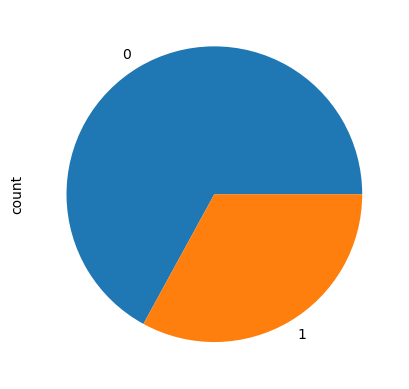

In [133]:
df['is_hate_speech'].value_counts().plot(kind='pie')

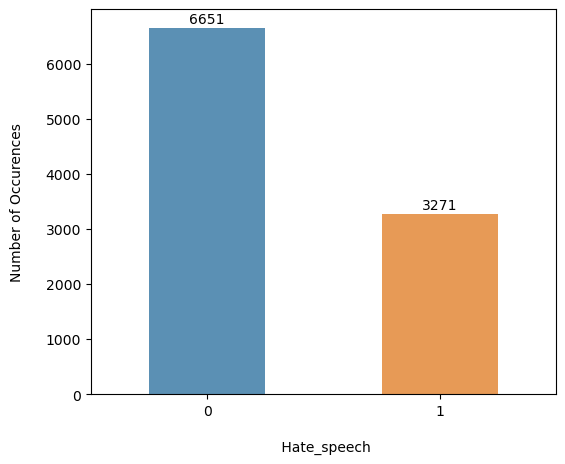

In [134]:
gender = df['is_hate_speech'].value_counts()
plt.figure(figsize=(6, 5))
ax = gender.plot(kind='bar', rot=0, color=["#5B90B4", "#E79A56"])
ax.set_xlabel('\n Hate_speech')
ax.set_ylabel('Number of Occurences\n')

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

The dataset is higly unbalanced. This should be taken into consideration when performing any supervised classification algorithm.

The other variable in the dataframe, beside the label, is the text of the tweets and header of the article. To understand the content, the most frequent words can be plotted into a wordcloud. Before doing this the variable is tokenized and the stopwords are removed.

#### verifica range temporale  dei tweet

avendo le date posso vedere come varia l'hate a livello temporale?? (per mesi)

In [135]:
df.head(2)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...


In [136]:
a = df['created_at'][0]
a

'2018-08-11'

In [137]:
#df.sort_values(by='created_at', ascending=True)

PERIODO TEMPORALE DI RIFERIMENTO: DAL 2018-08-11 AL 2021-09-03  - vedi plot 


#### prova plot date

In [138]:
type(df['created_at'][0])

str

In [139]:
# Assicurati che la colonna 'date' sia riconosciuta come tipo datetime
df['created_at'] = pd.to_datetime(df['created_at'])
type(df['created_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


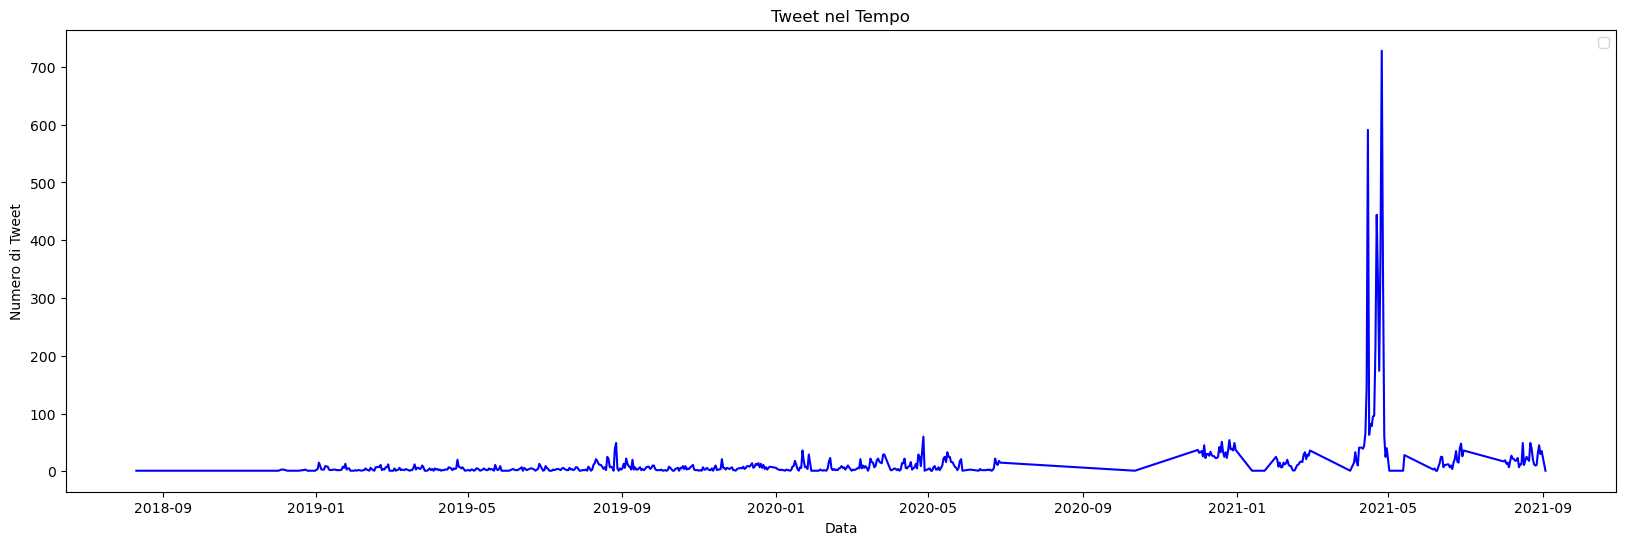

In [140]:
df_date_count = df.groupby('created_at').size()
plt.figure(figsize=(20, 6))
plt.plot(df_date_count.index, df_date_count.values, linestyle='-',  color='blue') #label='Hate Speech'

# Aggiungi legenda
plt.legend()

plt.title('Tweet nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
#plt.grid(True)
plt.show()

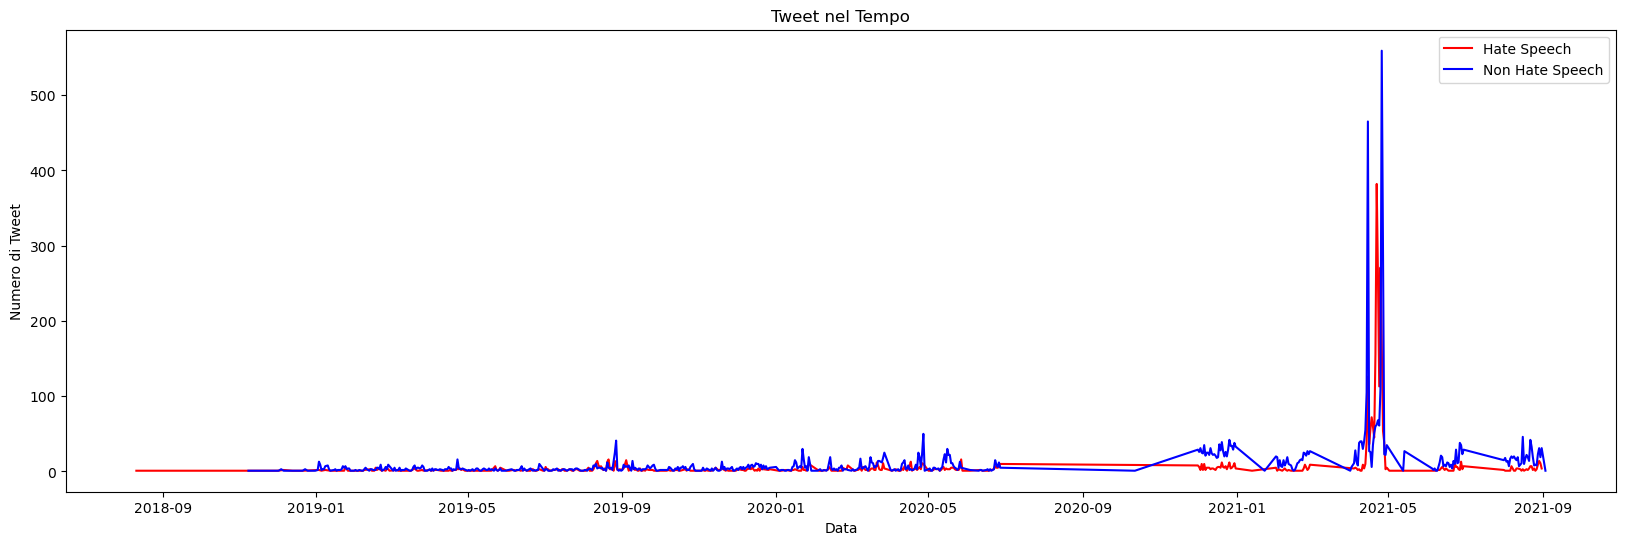

In [141]:
# Filtra i tweet d'odio
hate_speech_tweets = df[df['is_hate_speech'] == 1]
non_hate_speech_tweets = df[df['is_hate_speech'] == 0]

# Raggruppa per data e conta il numero di tweet d'odio per ogni data
hate_speech_count = hate_speech_tweets.groupby('created_at').size()
no_hate_speech_count = non_hate_speech_tweets.groupby('created_at').size()

# Plot
plt.figure(figsize=(20, 6))
plt.plot(hate_speech_count.index, hate_speech_count.values, linestyle='-',  color='red', label='Hate Speech')
plt.plot(no_hate_speech_count.index, no_hate_speech_count.values, linestyle='-', color='blue', label='Non Hate Speech')


# Aggiungi legenda
plt.legend()

plt.title('Tweet nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
#plt.grid(True)
plt.show()


#### qualche groupby di verifica

In [142]:
# Eseguire il groupby e sommare i valori della colonna 'favourite_count'
df.groupby('is_hate_speech')['favorite_count'].sum().reset_index() 

,is_hate_speech,favorite_count
0,0,357881.0
1,1,119290.0


In [143]:
df.groupby('is_hate_speech')['retweet_count'].sum().reset_index()

,is_hate_speech,retweet_count
0,0,92279.0
1,1,32551.0


#### creazione feature
“Weighted_Engagement = (a * retweet_count) + (b * favorite_count) + (c * is_reply) + (d * is_retweet) + (e * is_quote)”

In [144]:
# Supponiamo che df sia il tuo DataFrame e che tu abbia già le colonne retweet_count, favorite_count, is_reply, is_retweet, is_quote.

# Definire i pesi a, b, c, e
a = 0.5
b = 0.3
c = 0.1
e = 0.05

# Creare la nuova feature Weighted_Engagement
df['Weighted_Engagement'] = (a * df['retweet_count']) + (b * df['favorite_count']) + (c * df['is_reply'])  + (e * df['is_quote'])


In [145]:
df.sort_values(by='Weighted_Engagement', ascending=False)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,Weighted_Engagement
8510,653434672167167,Buon #25aprile a tutti!\nAnche ai politicanti ...,0,politics,2021-04-25,1541.0,23760.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,9.289431e+14,2011-03-16,10693.0,2613003.0,820.0,“Mille” con Achille Lauro e Orietta Berti👇🏻💖,7898.5
4551,25533696061829,Che poi i politici che non festeggiano non han...,0,politics,2021-04-25,1699.0,10022.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,8.866772e+14,2011-10-26,2329.0,276714.0,266.0,Felicemente insieme da 26 anni. Il nostro segr...,3856.1
1017,419845357201272,Dunque per convincere l'Europa a suddividere i...,0,politics,2019-09-23,1129.0,6043.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0.0,0.0,4.748887e+14,2010-09-16,63796.0,152796.0,2683.0,Sono buono 🇪🇺 Please don't be rude at anybody ...,2377.4
554,571216976106673,#salvini è come allenatore che pensa che per n...,0,politics,2019-07-07,1163.0,5154.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0.0,0.0,5.870494e+14,2013-06-05,25758.0,132172.0,13522.0,Rigore è quando arbitro fischia™ (non vero Bos...,2127.7
5617,249352738597455,"Tra i tagli automatici previsti dell’art.1, co...",0,politics,2019-01-06,1541.0,3913.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0.0,0.0,6.857592e+14,2017-12-12,2020.0,243995.0,64.0,Direttore Osservatorio sui Conti Pubblici Ital...,1944.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,423439009037687,"Un fiore per Aldo E Raffaele, le ACLI partecip...",0,religious,2021-04-27,0.0,0.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,3.254571e+14,2014-07-10,187.0,75.0,58.0,no_description,0.0
4022,188954913639758,Sondaggi politici elettorali oggi 23 aprile 20...,0,politics,2021-04-23,0.0,0.0,"<a href=""http://www.zazoom.it/"" rel=""nofollow""...",0.0,0.0,5.185091e+14,2010-12-29,3645754.0,5605.0,1544.0,Zazoom Social News ... Tutte le notizie dalle ...,0.0
4024,915574286462625,"Speranza tradito dal suo libro. ""Covid? Sapevo...",1,politics,2021-04-23,0.0,0.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,8.007252e+14,2010-05-04,33430.0,2629.0,2017.0,Periodista italo-venezolano \nDott. Mediatore ...,0.0
4027,133913007286830,#governodeipeggiori questo è il risultato del ...,1,politics,2021-04-23,0.0,0.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,9.744312e+14,2020-03-08,22340.0,459.0,459.0,no_description,0.0


In [146]:
#isolare gli hashtag e completare le righe che non ne hanno

def extract_hashtags(tweet):
    hashtags = [word for word in tweet.split() if word.startswith('#')]
    return ' '.join(hashtags) if hashtags else 'No hashtags'


In [147]:
df['Hash_words_tweet'] = df['tweet'].apply(extract_hashtags)
df['Hash_words_ad'] = df['anonymized_description'].apply(extract_hashtags)

In [148]:
df.head()

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,Weighted_Engagement,Hash_words_tweet,Hash_words_ad
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,1.9,No hashtags,No hashtags
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,211.4,#PRESCRIZIONE #m5s,No hashtags
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,6.908473e+14,2009-09-24,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",288.9,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,9.027930e+14,2012-11-27,3356.0,8493.0,5303.0,no_description,169.1,"#Lega #m5s #proceduradiinfrazione #Pd, #22nove...",No hashtags
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,5.308388e+14,2014-01-14,11234.0,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,65.4,#legge? #decretoinsicurezza #lega #delinquenti...,No hashtags


In [149]:
df['Hash_words_ad'].value_counts()

Hash_words_ad
No hashtags                                                               8568
#facciamorete                                                               35
#M5S                                                                        29
#PandadiSinistra                                                            17
#SalviniSciacalloDiMerda #RenziFuoriDallePalle #BoschiFuoriDaiCoglioni      16
                                                                          ... 
#Varese #notizie #news                                                       1
#freevax                                                                     1
#voltiditalia                                                                1
#PerNonDimenticare #NOallamafia #NOalladroga #AppleAddicted                  1
#Gab #Parler:                                                                1
Name: count, Length: 739, dtype: int64

## Data Analysis and Cleaning

Questa funzione `clean_text` sembra essere progettata per pulire il testo in un DataFrame Pandas, specificamente nel campo indicato da `text_field`. Ecco una spiegazione dei passaggi che la funzione esegue utilizzando espressioni regolari (regex):

1. `df[text_field] = df[text_field].str.lower()`: Trasforma tutti i caratteri nel campo del testo specificato in minuscolo. Questo aiuta a uniformare il testo, rendendolo case-insensitive durante le successive operazioni.

2. `df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))`: Utilizza la funzione `re.sub` del modulo regex di Python per sostituire i pattern corrispondenti con una stringa vuota (`""`).
   - `@[A-Za-z0-9]+`: Rimuove le menzioni degli utenti su piattaforme di social media, dove un nome utente inizia con '@' seguito da lettere e numeri.
   - `[^0-9A-Za-z \t]`: Rimuove tutti i caratteri che non sono lettere, numeri o spazi bianchi.
   - `(\w+:\/\/\S+)`: Rimuove le URL. Questo pattern corrisponde a sequenze che iniziano con lettere, numeri o caratteri di sottolineatura seguiti da "://" e qualsiasi cosa non sia uno spazio bianco.
   - `^rt`: Rimuove "RT" all'inizio del testo, che spesso è utilizzato per indicare un retweet su Twitter.
   - `http.+?`: Rimuove qualsiasi cosa che inizia con "http" seguito da uno o più caratteri qualsiasi (non greedy).

In sintesi, la funzione mira a ripulire il testo rimuovendo menzioni utente, caratteri speciali, URL, "RT" all'inizio del testo e qualsiasi cosa che sembri essere un link HTTP.

In [150]:
#crea nuova colonna pulita
def  clean_text(df, text_field):
    df['clean_'+text_field] = df[text_field].str.lower()
    df['clean_'+text_field] = df['clean_'+ text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [151]:
df = clean_text(df, "tweet")
df = clean_text(df, "anonymized_description")

df.head(3)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,...,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,...,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,1.9,No hashtags,No hashtags,con tutte le denunce che si sta beccando salv...,avete presente quegli stereotipi sui siciliani...
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,211.4,#PRESCRIZIONE #m5s,No hashtags,prescrizione i tre magi hanno trovato laccord...,prof di latino e deputata pdama lo sport la ro...
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,2009-09-24,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",288.9,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags,il m5s ha votato contro le unionicivili adduce...,medico appassionato di cinema dautore musica e...


In [152]:
#verifica 
print(df['tweet'][0])
print(df['clean_tweet'][0])

@unknown Con tutte le denunce che si sta beccando, Salvini rischia di far aumentare le statistiche dei reati commessi da italiani.
 con tutte le denunce che si sta beccando salvini rischia di far aumentare le statistiche dei reati commessi da italiani


In [153]:
print(df['tweet'][5])
print()
print(df['clean_tweet'][5])

@800991101440753 Spero rientrino 2000 insegnanti del Sud al Sud. Dopo 3 anni a Milano vorrei ricongiungermi alla mia famiglia. E non è neppure giusto che tramite le assegnazioni provvisorie gli alunni cambino insegnanti tutti gli anni. #legge107 #tempopieno @761724759091727 @26441249972320 @573256892148443

 spero rientrino 2000 insegnanti del sud al sud dopo 3 anni a milano vorrei ricongiungermi alla mia famiglia e non  neppure giusto che tramite le assegnazioni provvisorie gli alunni cambino insegnanti tutti gli anni legge107 tempopieno   


##### aggiungo colonne lunghezza_tweet e count delle parole


In [154]:
len(df['clean_tweet'][0])

120

In [155]:
df['tweet_len'] = df['clean_tweet'].astype(str).apply(len)
df['word_count'] = df['clean_tweet'].apply(lambda x: len(str(x).split()))

In [156]:
df.head(2)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,...,followers_count,friends_count,anonymized_description,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,...,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,1.9,No hashtags,No hashtags,con tutte le denunce che si sta beccando salv...,avete presente quegli stereotipi sui siciliani...,120,20
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,211.4,#PRESCRIZIONE #m5s,No hashtags,prescrizione i tre magi hanno trovato laccord...,prof di latino e deputata pdama lo sport la ro...,252,46


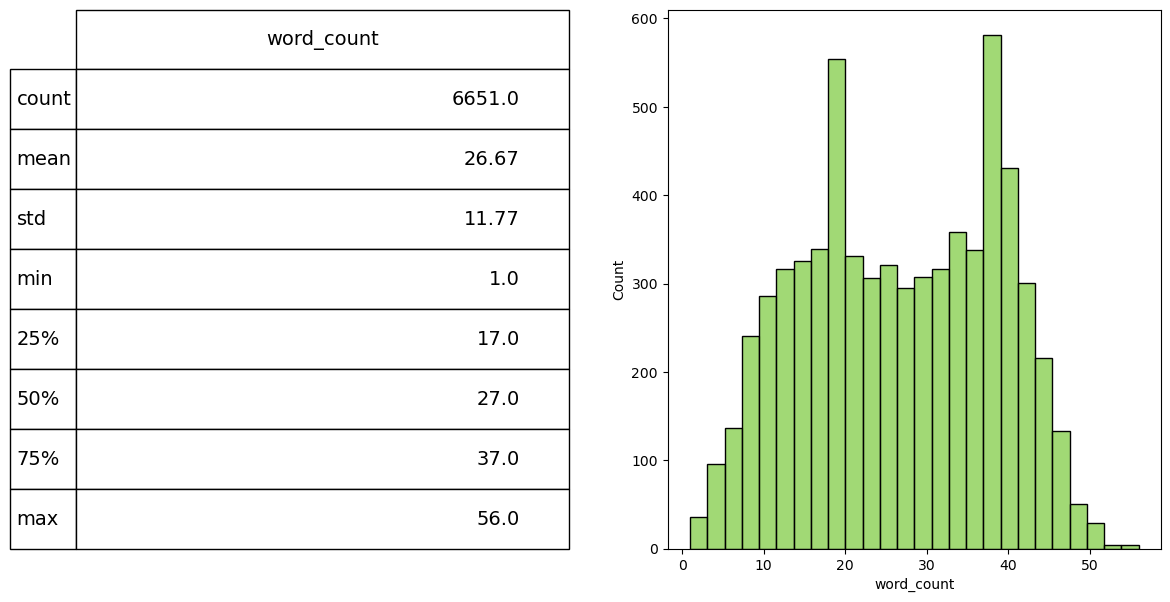

In [157]:
#classe 0 

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df[df['is_hate_speech']==0]['word_count'], ax=ax1,color='#82CD47')
describe = df["word_count"][df["is_hate_speech"]==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
#fig.suptitle('Distribution of text length for positive sentiment headlines.', fontsize=16)

plt.show()

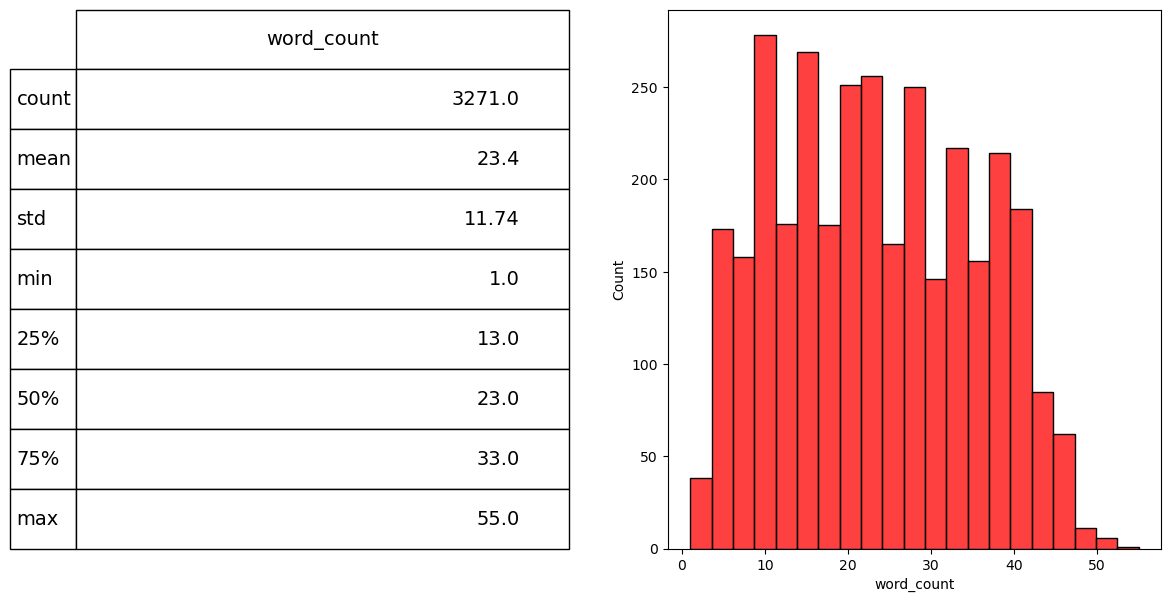

In [158]:
#classe 1

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df[df['is_hate_speech']==1]['word_count'], ax=ax1,color='#FF0000')
describe = df["word_count"][df["is_hate_speech"]==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
#fig.suptitle('Distribution of text length for negative sentiment headlines.', fontsize=16)

plt.show()

In [159]:
df.head()

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,...,followers_count,friends_count,anonymized_description,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,...,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,1.9,No hashtags,No hashtags,con tutte le denunce che si sta beccando salv...,avete presente quegli stereotipi sui siciliani...,120,20
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,211.4,#PRESCRIZIONE #m5s,No hashtags,prescrizione i tre magi hanno trovato laccord...,prof di latino e deputata pdama lo sport la ro...,252,46
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",288.9,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags,il m5s ha votato contro le unionicivili adduce...,medico appassionato di cinema dautore musica e...,255,40
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,...,8493.0,5303.0,no_description,169.1,"#Lega #m5s #proceduradiinfrazione #Pd, #22nove...",No hashtags,la lega e il m5s stanno dando a bere allopinio...,nodescription,244,37
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,...,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,65.4,#legge? #decretoinsicurezza #lega #delinquenti...,No hashtags,che cosa cambia questa legge caro con il decr...,veneto assessore regionale sviluppo economico ...,193,31


In [160]:
df.shape

(9922, 23)

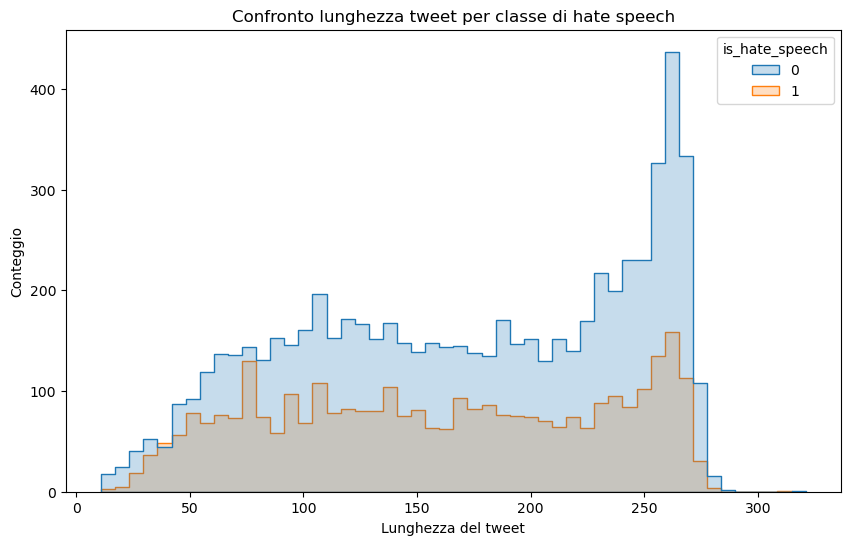

In [161]:
# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_len', hue='is_hate_speech', bins=50,  element="step", common_norm=False)

# Aggiungi titoli e etichette
plt.title('Confronto lunghezza tweet per classe di hate speech')
plt.xlabel('Lunghezza del tweet')
plt.ylabel('Conteggio')

# Mostra l'istogramma
plt.show()

ovvio sia cosi perche sono la metà

### Understanding e wordcloud

In [162]:
import nltk
nltk.download('stopwords')

# text cleaning
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
#italian stopwords
additional  = ['rt','rts','retweet'] 
swords = set().union(stopwords.words('italian'),additional) #italian
#swords

In [164]:
#creo colonna per le wordlcloud
df['to_wordcloud'] = df['clean_tweet'].apply(lambda x: [i for i in x.split() if not i in swords])

In [165]:
print(df['tweet'][0])
print(df['clean_tweet'][0])
print(df['to_wordcloud'][0])

@unknown Con tutte le denunce che si sta beccando, Salvini rischia di far aumentare le statistiche dei reati commessi da italiani.
 con tutte le denunce che si sta beccando salvini rischia di far aumentare le statistiche dei reati commessi da italiani
['tutte', 'denunce', 'beccando', 'salvini', 'rischia', 'far', 'aumentare', 'statistiche', 'reati', 'commessi', 'italiani']


In [166]:
#prova dividendo i domini
df_pol = df[df['dataset'] == 'politics']
df_rel = df[df['dataset'] == 'religious']

In [167]:
# wordcloud of the whole dataset
from wordcloud import WordCloud, STOPWORDS

bigstring     = df['to_wordcloud'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
bigstring_pol = df_pol['to_wordcloud'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
bigstring_rel = df_rel['to_wordcloud'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')

In [168]:
#levo anche le inglesi
#Since there are some very frequent words, which we already 
#know are the main topic of the dataset, we can remove them and re-do the wordcloud.

# wordcloud without some words INSERIRE QUELLE DA LEVARE
stopwords_1 = ["url", "cosa","perch",'solo', 'pi'] + list(STOPWORDS)
#stopwords_1

In [169]:
# #DATASET INTERO
# plt.figure(figsize=(12,12))
# wordcloud = WordCloud(stopwords=stopwords_1,
#                           background_color='white',
#                           collocations=False,
#                           width=1200,
#                           height=1000
#                          ).generate(bigstring)
# plt.axis('off')
# plt.imshow(wordcloud)

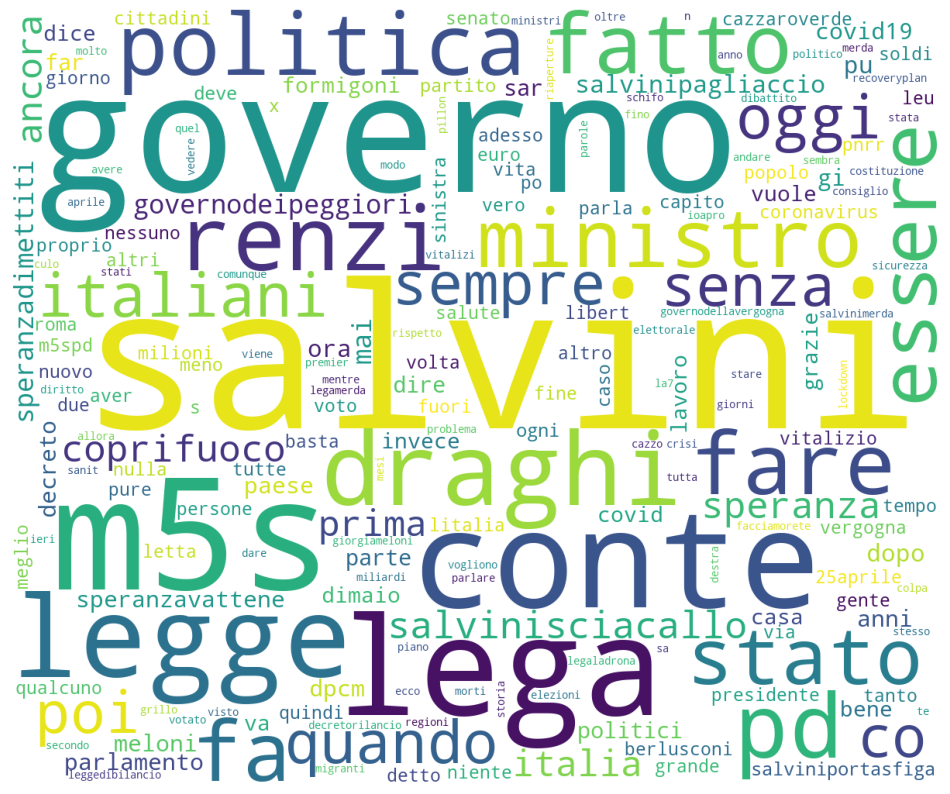

In [170]:
#DATASET POLITIC 
plt.figure(figsize=(12,12))
wordcloud1 = WordCloud(stopwords=stopwords_1,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring_pol)
plt.axis('off')
plt.imshow(wordcloud1)

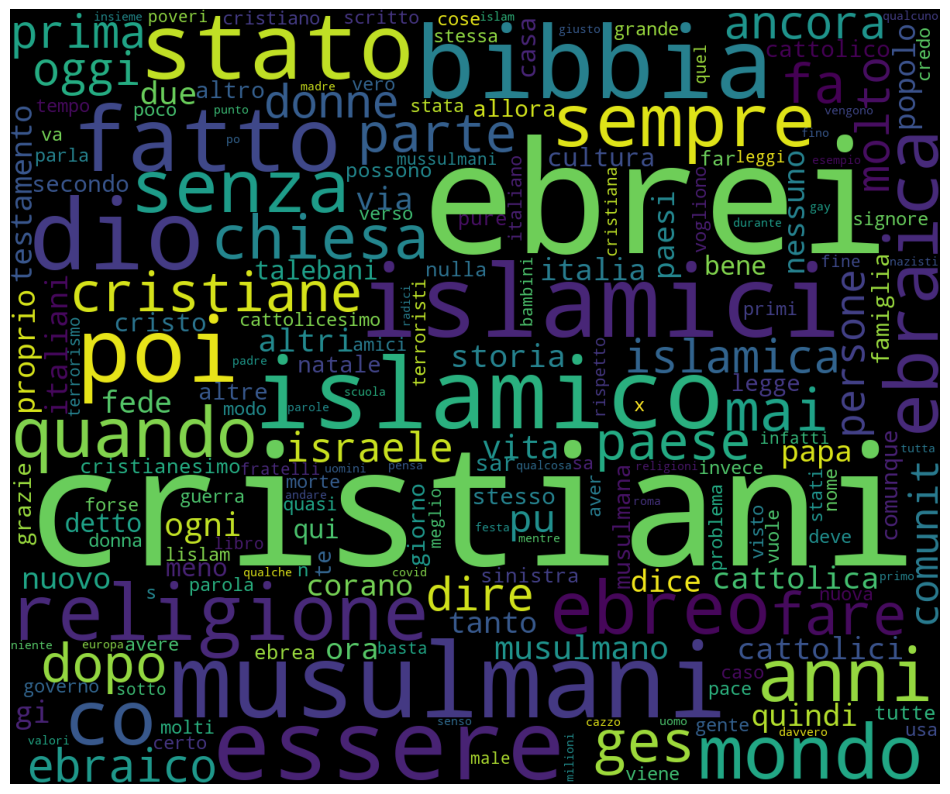

In [171]:
#DATASET RELIGIOUS
plt.figure(figsize=(12,12))
wordcloud2 = WordCloud(stopwords=stopwords_1,
                          background_color='black',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring_rel)
plt.axis('off')
plt.imshow(wordcloud2)

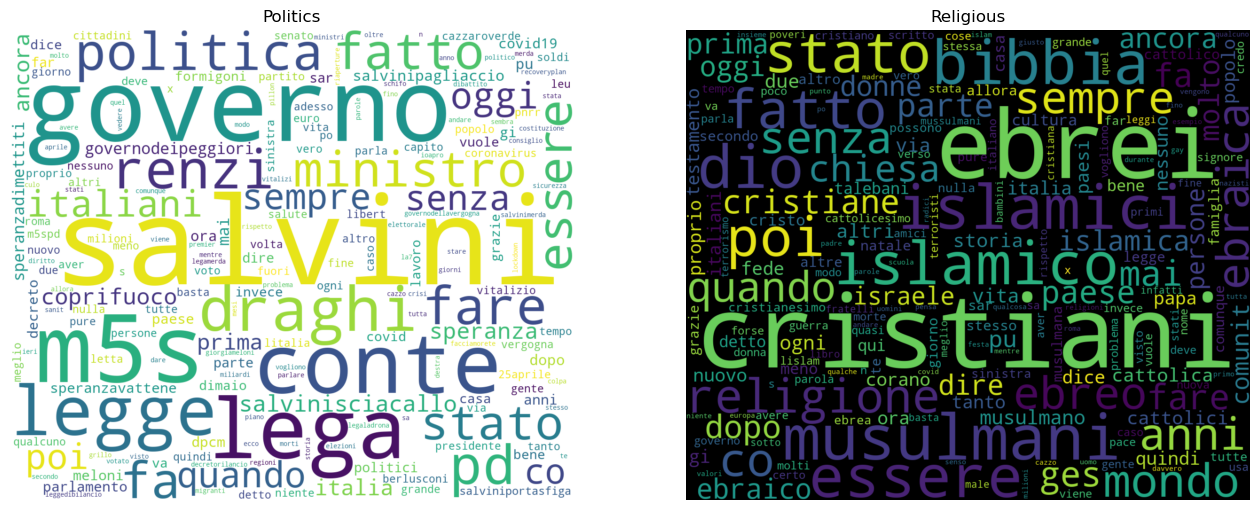

In [172]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))

axs[0].imshow(wordcloud1, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Politics')

axs[1].imshow(wordcloud2, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Religious')

plt.show()

##### grafico top words

In [173]:
# from nltk import FreqDist
# from nltk.tokenize import word_tokenize

# # Assicurati di aver tokenizzato correttamente il testo prima di procedere

# # Esempio di tokenizzazione (aggiorna in base alla tua implementazione)
# #df['to_wordcloud'] = df['to_wordcloud'].apply(lambda x: word_tokenize(x))

# # Unisci tutte le liste di parole in un'unica lista
# all_words = [word for words_list in df['to_wordcloud'] for word in words_list]

# # Lista di parole da rimuovere manualmente
# words_to_remove = ['url', 'solo', 'cosa', 'fare','sempre', 'quando']
# # Rimuovi le parole indesiderate dalla lista all_words
# all_words = [word for word in all_words if word not in words_to_remove]

# # Calcola la frequenza delle parole
# freq_dist = FreqDist(all_words)

# # Crea un dataframe con i dati della frequenza
# df_freq = pd.DataFrame(list(freq_dist.items()), columns=['Word', 'Frequency'])

# # Ordina il dataframe per frequenza in ordine decrescente
# df_freq = df_freq.sort_values(by='Frequency', ascending=False)

# # Limita il numero di parole da visualizzare nel plot (opzionale)
# top_words = 20
# df_freq = df_freq.head(top_words)

# # Crea il barplot
# plt.figure(figsize=(12, 6))
# plt.bar(df_freq['Word'], df_freq['Frequency'], color='skyblue')
# plt.xlabel('Words')
# plt.ylabel('Frequency')
# plt.title('Top {} Words in to_wordcloud Feature'.format(top_words))
# plt.xticks(rotation=45, ha='right')
# plt.show()


In [174]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet # Pos tagging correspondence

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS # Stop words
from gensim.models import Phrases # Compute bigrams.
from gensim.corpora import Dictionary # Utility to compute dictionary

# Ner visualization
import spacy
from spacy import displacy

In [184]:
df_preprocessed = df.copy()

### tweet tokenized e lemmatized  
parto dalla colonna di testo pulita e procedo con:
- rimozione stopwords ita e eng
- short words e parole inutili
- creo colonna tokenenized e lemmatized

Lo **stemming** è un processo che elimina o rimuove gli ultimi caratteri da una parola, spesso portando a significati e ortografia errati.\
La **lemmatizzazione** considera il contesto e converte la parola nella sua forma base significativa, chiamata Lemma.

In [185]:
df_preprocessed.head(2)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,...,friends_count,anonymized_description,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,...,753.0,Avete presente quegli stereotipi sui siciliani...,1.9,No hashtags,No hashtags,con tutte le denunce che si sta beccando salv...,avete presente quegli stereotipi sui siciliani...,120,20,"[tutte, denunce, beccando, salvini, rischia, f..."
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,211.4,#PRESCRIZIONE #m5s,No hashtags,prescrizione i tre magi hanno trovato laccord...,prof di latino e deputata pdama lo sport la ro...,252,46,"[prescrizione, tre, magi, trovato, laccordo, s..."


#### Tokeninzing the Text

In [186]:
import swifter
from nltk.tokenize import word_tokenize

df_preprocessed["tokenized_text"] = df_preprocessed.clean_tweet.swifter.apply(lambda x: word_tokenize(x))
df_preprocessed.head()

Pandas Apply:   0%|          | 0/9922 [00:00<?, ?it/s]

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,...,anonymized_description,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud,tokenized_text
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,...,Avete presente quegli stereotipi sui siciliani...,1.9,No hashtags,No hashtags,con tutte le denunce che si sta beccando salv...,avete presente quegli stereotipi sui siciliani...,120,20,"[tutte, denunce, beccando, salvini, rischia, f...","[con, tutte, le, denunce, che, si, sta, beccan..."
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,Prof di latino e Deputata PD.Ama lo sport la R...,211.4,#PRESCRIZIONE #m5s,No hashtags,prescrizione i tre magi hanno trovato laccord...,prof di latino e deputata pdama lo sport la ro...,252,46,"[prescrizione, tre, magi, trovato, laccordo, s...","[prescrizione, i, tre, magi, hanno, trovato, l..."
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,"Medico, appassionato di Cinema d'Autore, Music...",288.9,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags,il m5s ha votato contro le unionicivili adduce...,medico appassionato di cinema dautore musica e...,255,40,"[m5s, votato, unionicivili, adducendo, scuse, ...","[il, m5s, ha, votato, contro, le, unionicivili..."
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,...,no_description,169.1,"#Lega #m5s #proceduradiinfrazione #Pd, #22nove...",No hashtags,la lega e il m5s stanno dando a bere allopinio...,nodescription,244,37,"[lega, m5s, dando, bere, allopinione, pubblica...","[la, lega, e, il, m5s, stanno, dando, a, bere,..."
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,...,Veneto! Assessore Regionale Sviluppo Economico...,65.4,#legge? #decretoinsicurezza #lega #delinquenti...,No hashtags,che cosa cambia questa legge caro con il decr...,veneto assessore regionale sviluppo economico ...,193,31,"[cosa, cambia, legge, caro, decretoinsicurezza...","[che, cosa, cambia, questa, legge, caro, con, ..."


#### removing stopwords ITA ed EN +  Filtering out short words + parole inutili

In [187]:
import nltk
from nltk.corpus import stopwords

# Scarica le stop words italiane e inglesi
nltk.download('stopwords')
stop_words_italian = set(stopwords.words('italian'))
stop_words_english = set(stopwords.words('english'))

# Lista di parole personalizzate da rimuovere
custom_stop_words = ['url', 'volere', 'dire', 'fare']

# Funzione per rimuovere le stop words, le parole di una sola lettera e le parole personalizzate dalla lista di token
def remove_stopwords_and_short_words(token_list):
    return [word for word in token_list if len(word) > 1 and 
            word.lower() not in stop_words_italian and 
            word.lower() not in stop_words_english and 
            word.lower() not in custom_stop_words]

# Applica la nuova funzione alla colonna 'tokenized_tweet' del DataFrame
df_preprocessed['tokenized_text'] = df_preprocessed['tokenized_text'].apply(remove_stopwords_and_short_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [188]:
i= 0
print(len(df_preprocessed['to_wordcloud'][i]))
print(len(df_preprocessed['tokenized_text'][i]))

print((df_preprocessed['to_wordcloud'][i]))
print((df_preprocessed['tokenized_text'][i]))

11
11
['tutte', 'denunce', 'beccando', 'salvini', 'rischia', 'far', 'aumentare', 'statistiche', 'reati', 'commessi', 'italiani']
['tutte', 'denunce', 'beccando', 'salvini', 'rischia', 'far', 'aumentare', 'statistiche', 'reati', 'commessi', 'italiani']


#### Lemmatize the Tokens

La decisione di eseguire stemming e lemmatization dipende dal contesto specifico del tuo task di classificazione su testi. Entrambi i processi hanno l'obiettivo di ridurre le parole alla loro forma base, ma utilizzano approcci diversi per farlo.

1. **Stemming:**
   - **Obiettivo:** Ridurre le parole alla loro radice o "stemma" rimuovendo i suffissi.
   - **Esempio:** "Running" diventa "run", "happily" diventa "happi".

2. **Lemmatization:**
   - **Obiettivo:** Ridurre le parole alla loro forma canonica o base, tenendo conto del contesto e della parte del discorso.
   - **Esempio:** "Running" diventa "run", "better" diventa "good".

Ecco alcune considerazioni per entrambe le tecniche:

- **Stemming:**
  - È più aggressivo rispetto alla lemmatization, potrebbe produrre radici che non sono sempre parole corrette.
  - Può essere utile se la dimensione del tuo set di dati è un problema e desideri ridurre il numero di feature.
  - Potrebbe essere più adatto in casi in cui la precisione delle parole non è critica.

- **Lemmatization:**
  - Solitamente offre risultati più precisi, poiché tiene conto del significato delle parole nel contesto.
  - Può richiedere più risorse computazionali e tempo.
  - È utile quando la precisione delle parole è cruciale per la tua applicazione.

Nel contesto di un task di classificazione su testi, spesso si preferisce la lemmatization perché preserva meglio il significato delle parole. Tuttavia, la scelta dipende anche dalle caratteristiche specifiche del tuo set di dati e dal tuo obiettivo. Potresti anche sperimentare con entrambi i metodi e valutare quale produce risultati migliori per il tuo caso specifico.

In [189]:
import spacy #meglio usare spacy per lemmatization

# Carica il modello italiano di spaCy
nlp = spacy.load("it_core_news_sm")


# Definisci una lista di eccezioni che vuoi mantenere invariate durante la lemmatizzazione
lemmatization_exceptions = ["salvini"] #, "parola2", "parola3"


# Funzione per lemmatizzare una lista di token, mantenendo le eccezioni
def lemmatize_tokens_with_exceptions(token_list, exceptions):
    # Unisci la lista di token in una stringa per elaborare il testo con spaCy
    text = " ".join(token_list)
    
    # Processa il testo con spaCy
    doc = nlp(text)
    
    # Estrai lemmi dai token processati
    lemmatized_tokens = [token.lemma_ if token.lemma_ not in exceptions else token.text for token in doc]
    
    return lemmatized_tokens


# Applica la funzione alla colonna 'tokenized_tweet' del DataFrame
df_preprocessed['lemmatized_text'] = df_preprocessed['tokenized_text'].apply(lambda x: lemmatize_tokens_with_exceptions(x, lemmatization_exceptions))

In [194]:
#adesso salvini dovrebbe rimanere tale in lemmatized
i= 0
print(len(df_preprocessed['tokenized_text'][i]))
print(len(df_preprocessed['lemmatized_text'][i]))

print((df_preprocessed['tokenized_text'][i]))
print((df_preprocessed['lemmatized_text'][i]))

11
11
['tutte', 'denunce', 'beccando', 'salvini', 'rischia', 'far', 'aumentare', 'statistiche', 'reati', 'commessi', 'italiani']
['tutto', 'denuncia', 'beccare', 'salvino', 'rischiare', 'fare', 'aumentare', 'statistica', 'reato', 'commettere', 'italiano']


#### stemming dei token

In [195]:
from nltk.stem.snowball import SnowballStemmer

# Inizializza lo stemmer per l'italiano
stemmer = SnowballStemmer("italian")

# Funzione per eseguire lo stemming su una lista di token
def stem_tokens_italian(token_list):
    return [stemmer.stem(token) for token in token_list]

# Applica la funzione alla colonna 'tokenized_tweet' del DataFrame
df_preprocessed['stemmed_text'] = df_preprocessed['tokenized_text'].apply(stem_tokens_italian)


In [196]:
df_preprocessed.head(3)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,...,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud,tokenized_text,lemmatized_text,stemmed_text
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,...,No hashtags,No hashtags,con tutte le denunce che si sta beccando salv...,avete presente quegli stereotipi sui siciliani...,120,20,"[tutte, denunce, beccando, salvini, rischia, f...","[tutte, denunce, beccando, salvini, rischia, f...","[tutto, denuncia, beccare, salvino, rischiare,...","[tutt, denunc, becc, salvin, risc, far, aument..."
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,#PRESCRIZIONE #m5s,No hashtags,prescrizione i tre magi hanno trovato laccord...,prof di latino e deputata pdama lo sport la ro...,252,46,"[prescrizione, tre, magi, trovato, laccordo, s...","[prescrizione, tre, magi, trovato, laccordo, s...","[prescrizione, tre, mago, trovare, laccordo, s...","[prescrizion, tre, mag, trov, laccord, sar, pr..."
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,...,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags,il m5s ha votato contro le unionicivili adduce...,medico appassionato di cinema dautore musica e...,255,40,"[m5s, votato, unionicivili, adducendo, scuse, ...","[m5s, votato, unionicivili, adducendo, scuse, ...","[m5s, votare, unionicivile, adducere, scusa, v...","[m5s, vot, unionicivil, adduc, scus, vergogn, ..."


In [197]:
df_preprocessed.shape

(9922, 27)

In [198]:
# def create_corpus(df, nome_colonna_testo): 
#     corpus = []
#     for i in range(len(df)):  # Utilizza la lunghezza del DataFrame per evitare hardcoding del numero di righe
#         tweet = df[nome_colonna_testo][i]
#         tweet = ' '.join(tweet)
#         corpus.append(tweet)
#     return corpus

# corpus = create_corpus(df, 'tokenized_text')
# # Verifica che tutti i tweet siano tokenizzati in singole parole
# len(corpus)


In [199]:
#corpus[0]

**non so se ha senso usare le lemmatized:\
salvini - salvino\
lega - legare\
berlino - berlare\
...**

### creazione csv solo con colonne che mi interessano per analisi successive

In [200]:
# Specifica del percorso del file CSV
percorso_file_csv = 'df_preprocessed.csv'

# Salvataggio del DataFrame nel file CSV
df_preprocessed.to_csv(percorso_file_csv, index=False)